### Imports

In [1]:
from glob import glob
from scipy.ndimage import label
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import numpy as np
import pandas as pd
import os
import enum
import json
import glob

### Functions

In [2]:
class SegType(enum.Enum):
    NO_LABEL = 0
    GOLD_SEED = 1
    CALCIFICATION = 2

In [3]:
def get_cropped_regions(mask, vals, cropsize=10):
    
    labeled_mask, num_labels = label(
        input=mask,
        structure=np.ones((3, 3, 3))
    )

    cropped_regions = []
    cropped_masks = []

    for region_label in range(1, num_labels+1):
        coords = np.argwhere(labeled_mask == region_label)

        centroid = np.mean(coords, axis=0)
        centroid = np.round(centroid).astype(int)

        half_cropsize = cropsize // 2

        submask = mask[
            centroid[0]-half_cropsize:centroid[0]+half_cropsize,
            centroid[1]-half_cropsize:centroid[1]+half_cropsize,
            centroid[2]-half_cropsize:centroid[2]+half_cropsize
        ]
        subvals = vals[
            centroid[0]-half_cropsize:centroid[0]+half_cropsize,
            centroid[1]-half_cropsize:centroid[1]+half_cropsize,
            centroid[2]-half_cropsize:centroid[2]+half_cropsize
        ]

        cropped_regions.append(subvals)
        cropped_masks.append(submask)

    return cropped_regions, cropped_masks

In [4]:
def get_region_stats(seg, vals):
    counts = {}
    means = {}
    stds = {}

    for label_id in np.unique(seg):
        if label_id == 0: continue
        
        labels, num_labels = label(
            seg * np.array((seg == label_id), int),
            structure=np.ones((3, 3, 3))
        )

        region_counts = []
        region_means = []
        region_stds = []
        for i in range(1, num_labels+1):
            mask = (labels == i)
            region_counts.append(np.sum(mask))
            region_means.append(np.mean(vals[mask]))
            region_stds.append(np.std(vals[mask]))

        counts[label_id] = region_counts
        means[label_id] = region_means
        stds[label_id] = region_stds

    return counts, means, stds

In [5]:
def update_dict(original_dict, other_dict):
    for key in original_dict:
        if key in other_dict:
            original_dict[key].extend(other_dict[key])
        else:
            original_dict[key] = other_dict[key]
    return original_dict

### Load data

In [6]:
bids_dir = "bids-new"

In [7]:
session_dirs = []
for json_path in sorted(glob.glob(os.path.join(bids_dir, "sub*", "ses*", "anat", "*echo-01*mag*json"))):
    with open(json_path, 'r') as json_file:
        json_data = json.load(json_file)
        if json_data['ProtocolName'] == "t2starME_qsm_tra_Iso1.4mm_INPHASE_bipolar_RUN_THIS_ONE":
            session_dirs.append(os.sep.join(os.path.split(json_path)[0].split(os.sep)[:-1]))
print(f"{len(session_dirs)} sessions found:")
for session_dir in session_dirs: print(session_dir)

24 sessions found:
bids-new/sub-z0034542/ses-20220715
bids-new/sub-z0182923/ses-20230705
bids-new/sub-z0186251/ses-20221107
bids-new/sub-z0237546/ses-20230508
bids-new/sub-z0317485/ses-20230517
bids-new/sub-z0445614/ses-20230510
bids-new/sub-z0705200/ses-20230104
bids-new/sub-z0755228/ses-20211108
bids-new/sub-z1167038/ses-20220315
bids-new/sub-z1181657/ses-20220315
bids-new/sub-z1262112/ses-20220314
bids-new/sub-z1472355/ses-20221222
bids-new/sub-z1568577/ses-20230510
bids-new/sub-z1571613/ses-20230519
bids-new/sub-z1728751/ses-20220328
bids-new/sub-z1778013/ses-20220715
bids-new/sub-z1818796/ses-20230313
bids-new/sub-z2007565/ses-20220715
bids-new/sub-z2900812/ses-20230523
bids-new/sub-z2904752/ses-20220826
bids-new/sub-z2952003/ses-20230614
bids-new/sub-z3171177/ses-20230313
bids-new/sub-z3278008/ses-20211109
bids-new/sub-z3393287/ses-20230524


In [8]:
extra_files = sum((glob.glob(os.path.join(session_dir, "extra_data", "*.nii*")) for session_dir in session_dirs), [])

qsm_files = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "*qsm_echo2-and-echo4.*")) for session_dir in session_dirs), []))
t2s_files = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "*t2starmap.nii*")) for session_dir in session_dirs), []))
mag_files = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "magnitude_combined.nii")) for session_dir in session_dirs), []))
swi_files = sorted(sum((glob.glob(os.path.join(session_dir, "extra_data", "swi.nii")) for session_dir in session_dirs), []))

gre_seg_raw_files = [extra_file for extra_file in extra_files if all(pattern in extra_file for pattern in ['_segmentation.', 'run'])]
gre_seg_clean_files = [seg_file.replace(".nii", "_clean.nii") for seg_file in gre_seg_raw_files if os.path.exists(seg_file.replace(".nii", "_clean.nii"))]

t1_files = [extra_file for extra_file in extra_files if any(pattern in extra_file for pattern in ['_T1w', '_t1_tra']) and not any(pattern in extra_file for pattern in ['_Pelvis_', '.json', '_resampled'])]
t1_files = [t1_file.replace("_resampled", "") for t1_file in t1_files]
t1_resampled_files = [t1_file.replace(".nii", "_resampled.nii") for t1_file in t1_files if os.path.exists(t1_file.replace(".nii", "_resampled.nii"))]

ct_files = [extra_file for extra_file in extra_files if 'resliced' in extra_file and any(pattern in extra_file for pattern in ['_na_', '_Pelvis_', '_NA']) and not any(pattern in extra_file for pattern in ['_t1_tra_', 'ATX', 'AXT', 'ROI', 'segmentation', '.json'])]
ct_seg_raw_files = sum((glob.glob(ct_file.replace(".nii", "_segmentation.nii")) for ct_file in ct_files), [])
ct_seg_clean_files = [ct_file.replace("_segmentation", "_segmentation_clean") for ct_file in ct_seg_raw_files if os.path.exists(ct_file)]

print(f"{len(ct_files)} CT images found.")
print(f"{len(ct_seg_raw_files)} raw CT segmentations found.")
print(f"{len(ct_seg_clean_files)} clean CT segmentations found.")
print(f"{len(qsm_files)} QSM images found.")
print(f"{len(mag_files)} magnitude images found.")
print(f"{len(t2s_files)} T2* maps found.")
print(f"{len(swi_files)} SWI maps found.")
print(f"{len(t1_files)} T1w files found.")
print(f"{len(t1_resampled_files)} resampled T1w files found.")
print(f"{len(gre_seg_raw_files)} raw GRE segmentations found.")
print(f"{len(gre_seg_clean_files)} clean GRE segmentations found.")

24 CT images found.
24 raw CT segmentations found.
24 clean CT segmentations found.
24 QSM images found.
24 magnitude images found.
24 T2* maps found.
24 SWI maps found.
24 T1w files found.
24 resampled T1w files found.
24 raw GRE segmentations found.
24 clean GRE segmentations found.


In [9]:
input_images = t2s_files
input_segmentations = gre_seg_clean_files

In [10]:
class SegType(enum.Enum):
    NO_LABEL = 0
    PROSTATE = 1
    GOLD_SEED = 2
    CALCIFICATION = 3

class SegTypeFinal(enum.Enum):
    NO_LABEL = 0
    GOLD_SEED = 1
    CALCIFICATION = 2

prostate_means = []
prostate_stds = []
for i in range(len(t2s_files)):
    # load files
    input_nii = nib.load(t2s_files[i])
    seg_nii = nib.load(gre_seg_raw_files[i])

    # get image data
    input_data = input_nii.get_fdata()
    seg = np.array(seg_nii.get_fdata(), dtype=np.uint8)

    # separate prostate tissue values and then remove segmented area
    values = input_data[seg == SegType.PROSTATE.value].flatten()
    #values = values[values != np.inf]
    #values = values[values >= 0]
    #values = values[values <= 100]
    values = np.logical_and(values != np.inf, values > 0)
    prostate_means.append(values.mean())
    prostate_stds.append(values.std())
prostate_means

[0.9111389236545682,
 0.9325236167341431,
 0.8272335844994618,
 0.8546458141674333,
 0.7844243792325056,
 0.8454172366621067,
 0.8782722513089005,
 0.8486759142496847,
 0.863905325443787,
 0.8726655348047538,
 0.84224049331963,
 0.8544061302681992,
 0.8151183970856102,
 0.9508196721311475,
 0.8278688524590164,
 0.7516949152542373,
 0.7210884353741497,
 0.8673740053050398,
 0.9130434782608695,
 0.7330703484549639,
 0.856551724137931,
 0.7661900756938604,
 0.807564698075647,
 0.8325688073394495]

In [11]:
seed_sizes = []
seed_means = []
seed_stds = []
seed_segmentations = []
regions_vals = []
regions_masks = []
regions_segmentations = []

for i in range(len(input_segmentations)):
    # load images
    print(input_segmentations[i])
    seg = nib.load(input_segmentations[i]).get_fdata()
    input_data = nib.load(input_images[i]).get_fdata()
    input_data[input_data == np.inf] = 100
    input_data[input_data < 0] = 0
    input_data[input_data > 100] = 100
    input_data[np.isnan(input_data)] = 0

    # get region stats
    counts, means, stds = get_region_stats(seg, input_data)
    try:
        seed_sizes.extend(counts[SegTypeFinal.GOLD_SEED.value])
        seed_means.extend(means[SegTypeFinal.GOLD_SEED.value])
        seed_stds.extend(stds[SegTypeFinal.GOLD_SEED.value])
        seed_segmentations.extend(os.path.split(input_segmentations[i])[1] for x in range(len(counts[SegTypeFinal.GOLD_SEED.value])))
    except:
        print(f"No goldseed found in {input_segmentations[i]}")
        continue

    # get regions
    connected_regions_vals, connected_regions_masks = get_cropped_regions(
        mask=seg == SegTypeFinal.GOLD_SEED.value,
        vals=input_data,
        cropsize=20
    )
    regions_vals.extend(connected_regions_vals)
    regions_masks.extend(connected_regions_masks)
    regions_segmentations.extend([input_segmentations[i] for x in range(len(connected_regions_vals))])


# create dataframe
seed_data = {
    "size": seed_sizes,
    "mean": seed_means,
    "std": seed_stds,
    "file" : seed_segmentations
}
seed_df = pd.DataFrame(seed_data).sort_values("size")

bids-new/sub-z0034542/ses-20220715/extra_data/sub-z0034542_ses-20220715_run-01_segmentation_clean.nii.gz
bids-new/sub-z0182923/ses-20230705/extra_data/sub-z0182923_ses-20230705_run-01_segmentation_clean.nii
bids-new/sub-z0186251/ses-20221107/extra_data/sub-z0186251_ses-20221107_run-01_segmentation_clean.nii.gz
bids-new/sub-z0237546/ses-20230508/extra_data/sub-z0237546_ses-20230508_run-01_segmentation_clean.nii
bids-new/sub-z0317485/ses-20230517/extra_data/sub-z0317485_ses-20230517_run-01_segmentation_clean.nii
bids-new/sub-z0445614/ses-20230510/extra_data/sub-z0445614_ses-20230510_run-01_segmentation_clean.nii
bids-new/sub-z0705200/ses-20230104/extra_data/sub-z0705200_ses-20230104_run-01_segmentation_clean.nii
bids-new/sub-z0755228/ses-20211108/extra_data/sub-z0755228_ses-20211108_run-01_segmentation_clean.nii.gz
bids-new/sub-z1167038/ses-20220315/extra_data/sub-z1167038_ses-20220315_run-01_segmentation_clean.nii.gz
bids-new/sub-z1181657/ses-20220315/extra_data/sub-z1181657_ses-2022031

In [12]:
seed_df.sort_values("file")

,size,mean,std,file
0,40,14.314086,21.216874,sub-z0034542_ses-20220715_run-01_segmentation_...
1,36,8.260950,6.710582,sub-z0034542_ses-20220715_run-01_segmentation_...
2,28,11.110383,12.098927,sub-z0034542_ses-20220715_run-01_segmentation_...
5,39,15.972864,19.589984,sub-z0182923_ses-20230705_run-01_segmentation_...
3,36,9.989737,16.310364,sub-z0182923_ses-20230705_run-01_segmentation_...
...,...,...,...,...
67,26,5.893181,4.343518,sub-z3278008_ses-20211109_run-01_segmentation_...
68,37,13.707804,17.936803,sub-z3278008_ses-20211109_run-01_segmentation_...
69,35,18.128643,19.021132,sub-z3393287_ses-20230524_run-01_segmentation_...
71,29,13.818412,18.219587,sub-z3393287_ses-20230524_run-01_segmentation_...


### Visualise data

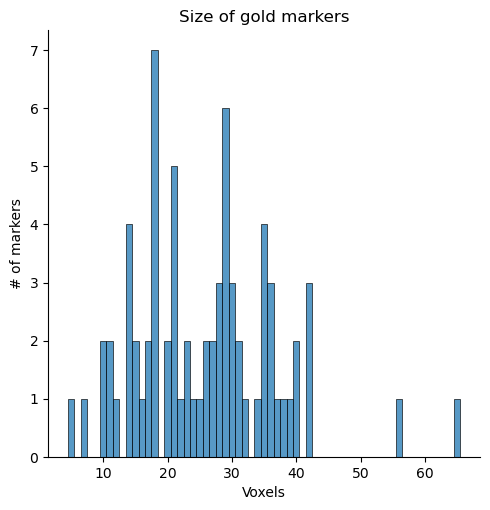

In [13]:
sns.displot(seed_data, x='size', discrete=True)
plt.xlabel("Voxels")
plt.ylabel("# of markers")
plt.title("Size of gold markers")
plt.savefig("seed_size_histogram_t2s.png", bbox_inches='tight')
plt.show()

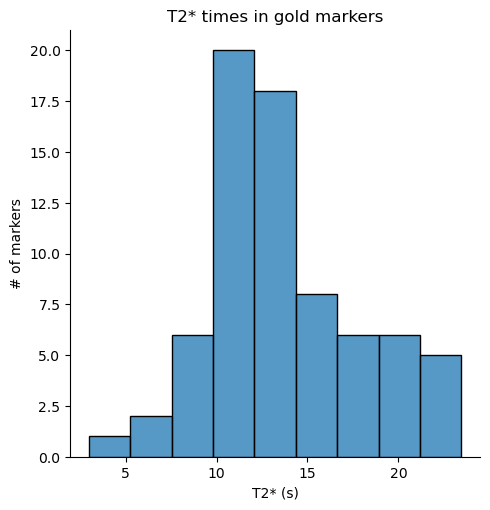

In [14]:
sns.displot(seed_data, x='mean')
plt.xlabel("T2* (s)")
plt.ylabel("# of markers")
plt.title("T2* times in gold markers")
plt.savefig("seed_histogram_t2s.png", bbox_inches='tight')
plt.show()

In [15]:
for i in regions_vals:
    print(i.shape)

(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)
(20, 20, 20)


72


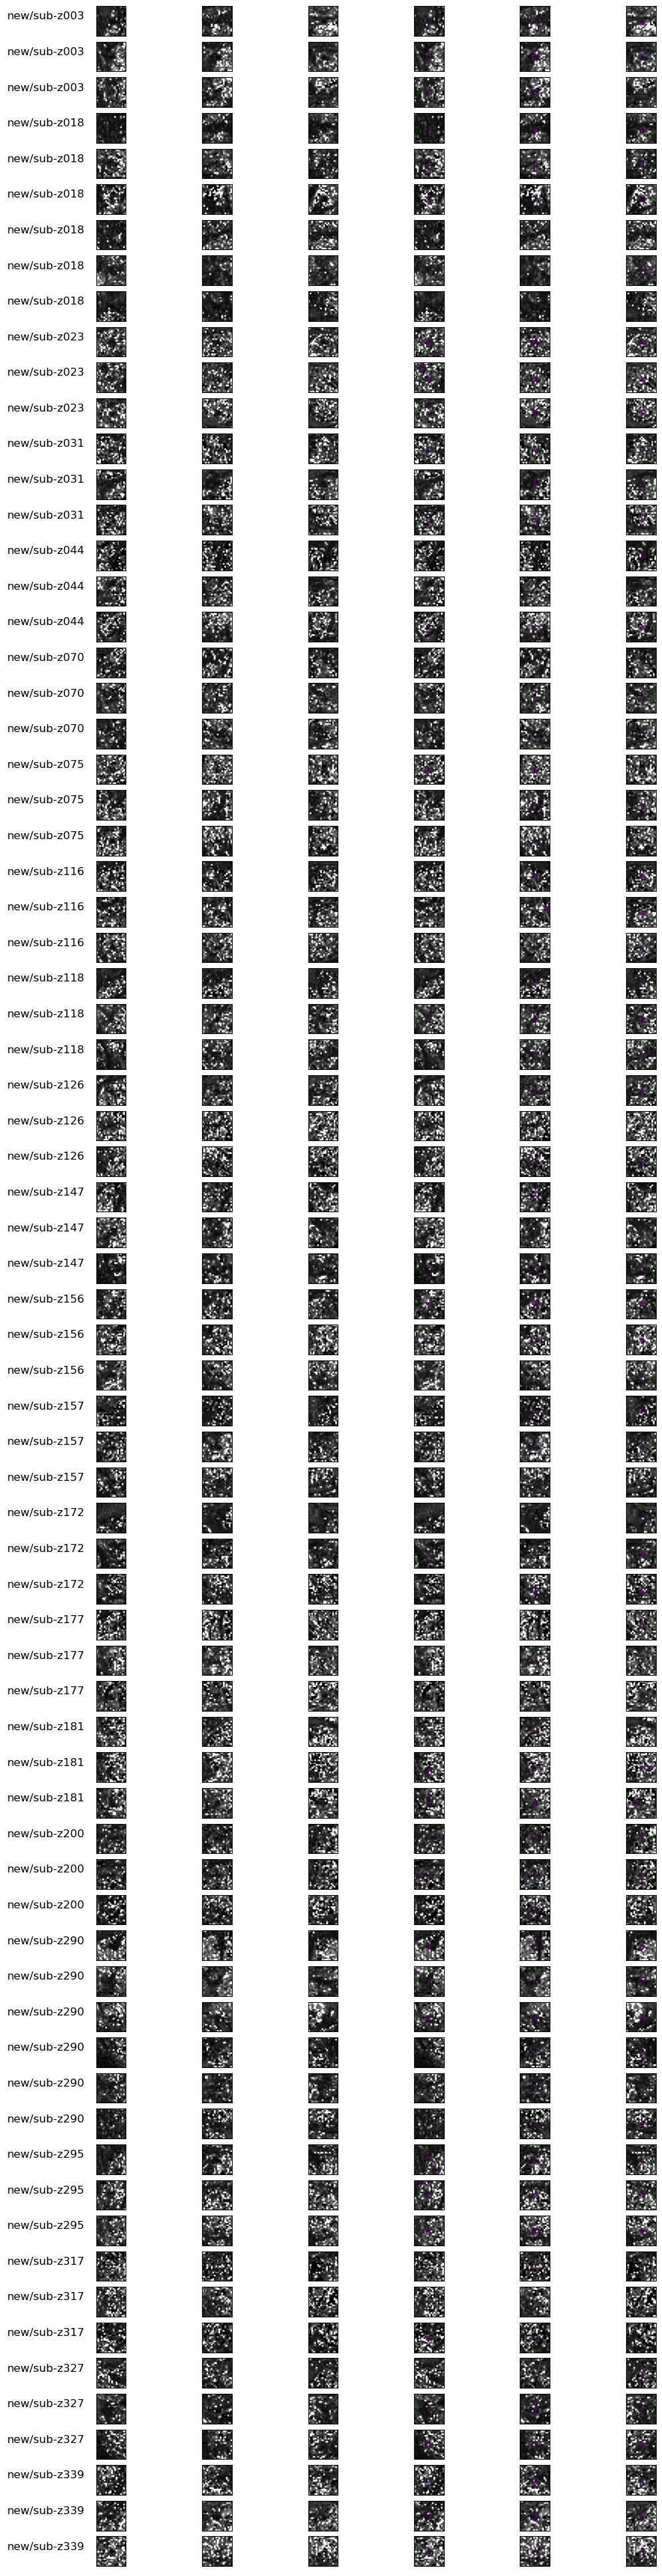

In [16]:
fig, axes = plt.subplots(ncols=6, nrows=len(regions_vals), figsize=(12, 50))

for ax in axes.flat:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

vmin=0
vmax=80
print(len(regions_vals))
for i in range(len(regions_vals)):
    try:
        axes[i,0].imshow(regions_vals[i][regions_vals[i].shape[0]//2,:,:], cmap='gray', vmin=vmin, vmax=vmax)
        axes[i,1].imshow(regions_vals[i][:,regions_vals[i].shape[1]//2,:], cmap='gray', vmin=vmin, vmax=vmax)
        axes[i,2].imshow(regions_vals[i][:,:,regions_vals[i].shape[2]//2], cmap='gray', vmin=vmin, vmax=vmax)

        axes[i,3].imshow(regions_vals[i][regions_vals[i].shape[0]//2,:,:], cmap='gray', vmin=vmin, vmax=vmax)
        axes[i,4].imshow(regions_vals[i][:,regions_vals[i].shape[1]//2,:], cmap='gray', vmin=vmin, vmax=vmax)
        axes[i,5].imshow(regions_vals[i][:,:,regions_vals[i].shape[2]//2], cmap='gray', vmin=vmin, vmax=vmax)

        axes[i,3].imshow(regions_masks[i][regions_vals[i].shape[0]//2,:,:], cmap='cool', alpha=np.array(regions_masks[i][regions_vals[i].shape[0]//2,:,:] * 0.2, dtype=float), vmin=0, vmax=1)
        axes[i,4].imshow(regions_masks[i][:,regions_vals[i].shape[1]//2,:], cmap='cool', alpha=np.array(regions_masks[i][:,regions_vals[i].shape[1]//2,:] * 0.2, dtype=float), vmin=0, vmax=1)
        axes[i,5].imshow(regions_masks[i][:,:,regions_vals[i].shape[2]//2], cmap='cool', alpha=np.array(regions_masks[i][:,:,regions_vals[i].shape[2]//2] * 0.2, dtype=float), vmin=0, vmax=1)
    except:
        continue
    axes[i,0].set_ylabel(regions_segmentations[i][5:17], rotation=0, fontsize=12, labelpad=55)

plt.savefig("seeds_t2s.png", bbox_inches='tight')
plt.show()
plt.close()

In [30]:
calc_sizes = []
calc_means = []
calc_stds = []
calc_segmentations = []
regions_vals = []
regions_masks = []
regions_segmentations = []

for i in range(len(input_segmentations)):
    # load images
    print(i)
    seg = nib.load(input_segmentations[i]).get_fdata()
    data = nib.load(input_images[i]).get_fdata()
    data[np.isnan(data)] = 0
    data[data == np.inf] = 100
    data[data < 0] = 0
    data[data > 100] = 100

    # get region stats
    counts, means, stds = get_region_stats(seg, data)
    print(counts)
    try:
        calc_sizes.extend(counts[SegTypeFinal.CALCIFICATION.value])
        calc_means.extend(means[SegTypeFinal.CALCIFICATION.value])
        calc_stds.extend(stds[SegTypeFinal.CALCIFICATION.value])
        calc_segmentations.extend(os.path.split(input_segmentations[i])[1] for x in range(len(counts[SegTypeFinal.CALCIFICATION.value])))
    except:
        print(f"No calcification found in {input_segmentations[i]}")
        continue

    # get regions
    connected_regions_vals, connected_regions_masks = get_cropped_regions(
        mask=seg == SegTypeFinal.CALCIFICATION.value,
        vals=data,
        cropsize=20
    )
    regions_vals.extend(connected_regions_vals)
    regions_masks.extend(connected_regions_masks)
    regions_segmentations.extend([input_segmentations[i] for x in range(len(connected_regions_vals))])


# create dataframe
calc_data = {
    "size": calc_sizes,
    "mean": calc_means,
    "std": calc_stds,
    "file" : calc_segmentations
}
calc_df = pd.DataFrame(calc_data).sort_values("size")

0
{1.0: [40, 36, 28]}
No calcification found in bids-new/sub-z0034542/ses-20220715/extra_data/sub-z0034542_ses-20220715_run-01_segmentation_clean.nii.gz
1
{1.0: [36, 30, 39]}
No calcification found in bids-new/sub-z0182923/ses-20230705/extra_data/sub-z0182923_ses-20230705_run-01_segmentation_clean.nii
2
{1.0: [7, 22, 5]}
No calcification found in bids-new/sub-z0186251/ses-20221107/extra_data/sub-z0186251_ses-20221107_run-01_segmentation_clean.nii.gz
3
{1.0: [65, 35, 29]}
No calcification found in bids-new/sub-z0237546/ses-20230508/extra_data/sub-z0237546_ses-20230508_run-01_segmentation_clean.nii
4
{1.0: [35, 28, 31], 2.0: [8, 16]}
5
{1.0: [10, 18, 29], 2.0: [22, 11, 9, 4, 2]}
6
{1.0: [11, 18, 17], 2.0: [23, 4, 7, 14, 33, 154, 4, 14]}
7
{1.0: [40, 25, 26], 2.0: [22, 95, 2, 4, 3, 2, 6, 2, 2, 8, 37, 12, 2, 19, 3, 1, 51, 1, 17]}
8
{1.0: [29, 21, 30], 2.0: [2, 1, 4, 1, 16, 1]}
9
{1.0: [28, 31, 34]}
No calcification found in bids-new/sub-z1181657/ses-20220315/extra_data/sub-z1181657_ses-202

In [31]:
calc_df

,size,mean,std,file
39,1,10.220880,0.000000,sub-z1167038_ses-20220315_run-01_segmentation_...
32,1,100.000000,0.000000,sub-z0755228_ses-20211108_run-01_segmentation_...
35,1,14.254113,0.000000,sub-z1167038_ses-20220315_run-01_segmentation_...
37,1,5.898613,0.000000,sub-z1167038_ses-20220315_run-01_segmentation_...
30,1,13.650664,0.000000,sub-z0755228_ses-20211108_run-01_segmentation_...
54,2,7.353004,1.947611,sub-z3278008_ses-20211109_run-01_segmentation_...
34,2,14.302011,4.548670,sub-z1167038_ses-20220315_run-01_segmentation_...
23,2,23.189984,4.061164,sub-z0755228_ses-20211108_run-01_segmentation_...
22,2,7.143750,7.143750,sub-z0755228_ses-20211108_run-01_segmentation_...
20,2,59.103618,40.896382,sub-z0755228_ses-20211108_run-01_segmentation_...


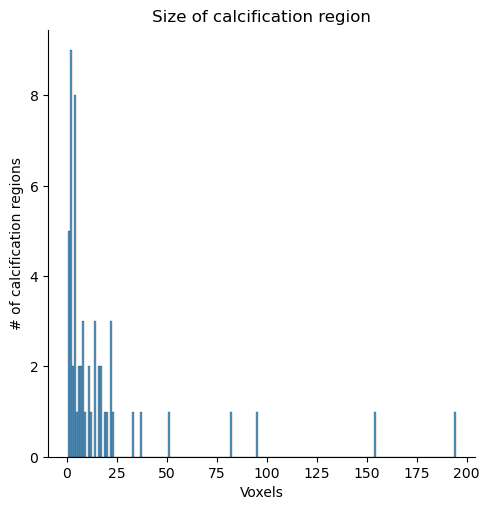

In [55]:
sns.displot(calc_data, x='size', discrete=True)
plt.xlabel("Voxels")
plt.ylabel("# of calcification regions")
#plt.xlim(0, 50)
plt.title("Size of calcification region")
plt.savefig("calc_size_histogram.png", bbox_inches='tight')
plt.show()

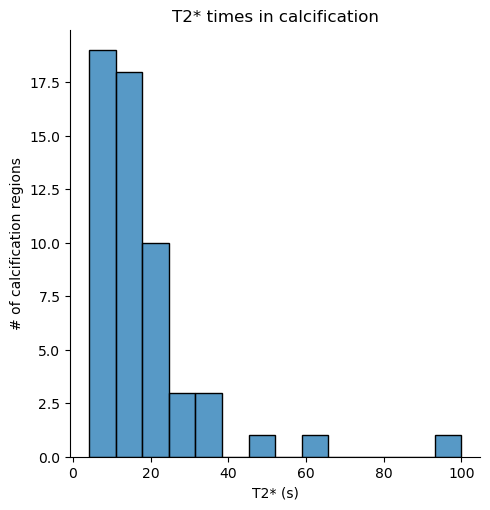

In [32]:
sns.displot(calc_data, x='mean')
plt.xlabel("T2* (s)")
plt.ylabel("# of calcification regions")
plt.title("T2* times in calcification")
plt.savefig("calc_histogram_t2s.png", bbox_inches='tight')
plt.show()

In [33]:
subset = calc_df[calc_df['size'] >= (seed_df['size'].mean() - 3*seed_df['size'].std())]
subset = subset[subset['size'] <= (seed_df['size'].mean() + 3*seed_df['size'].std())]
subset['Type'] = 'Calcification'
subset.sort_values('size')

,size,mean,std,file,Type
39,1,10.220880,0.000000,sub-z1167038_ses-20220315_run-01_segmentation_...,Calcification
32,1,100.000000,0.000000,sub-z0755228_ses-20211108_run-01_segmentation_...,Calcification
35,1,14.254113,0.000000,sub-z1167038_ses-20220315_run-01_segmentation_...,Calcification
37,1,5.898613,0.000000,sub-z1167038_ses-20220315_run-01_segmentation_...,Calcification
30,1,13.650664,0.000000,sub-z0755228_ses-20211108_run-01_segmentation_...,Calcification
6,2,8.510515,8.510515,sub-z0445614_ses-20230510_run-01_segmentation_...,Calcification
27,2,4.948919,1.389681,sub-z0755228_ses-20211108_run-01_segmentation_...,Calcification
17,2,8.525172,8.525172,sub-z0755228_ses-20211108_run-01_segmentation_...,Calcification
20,2,59.103618,40.896382,sub-z0755228_ses-20211108_run-01_segmentation_...,Calcification
42,2,8.062642,0.595911,sub-z1571613_ses-20230519_run-01_segmentation_...,Calcification


In [34]:
seed_df['Type'] = 'FM'

In [35]:
prostate_data = {
    "size": 1,
    "mean": np.array(prostate_means),
    "std": np.array(prostate_stds),
    "file": "",
    "Type": "Prostate"
}
prostate_df = pd.DataFrame(prostate_data)
prostate_df

,size,mean,std,file,Type
0,1,0.911139,0.284543,,Prostate
1,1,0.932524,0.250845,,Prostate
2,1,0.827234,0.378045,,Prostate
3,1,0.854646,0.352458,,Prostate
4,1,0.784424,0.411221,,Prostate
5,1,0.845417,0.361506,,Prostate
6,1,0.878272,0.326971,,Prostate
7,1,0.848676,0.358364,,Prostate
8,1,0.863905,0.342889,,Prostate
9,1,0.872666,0.333347,,Prostate


In [36]:
combined_df = pd.concat([subset, seed_df, prostate_df])
combined_df = combined_df.replace([np.inf, -np.inf], np.nan)
combined_df = combined_df.dropna()
combined_df

,size,mean,std,file,Type
39,1,10.220880,0.000000,sub-z1167038_ses-20220315_run-01_segmentation_...,Calcification
32,1,100.000000,0.000000,sub-z0755228_ses-20211108_run-01_segmentation_...,Calcification
35,1,14.254113,0.000000,sub-z1167038_ses-20220315_run-01_segmentation_...,Calcification
37,1,5.898613,0.000000,sub-z1167038_ses-20220315_run-01_segmentation_...,Calcification
30,1,13.650664,0.000000,sub-z0755228_ses-20211108_run-01_segmentation_...,Calcification
...,...,...,...,...,...
19,1,0.733070,0.442355,,Prostate
20,1,0.856552,0.350529,,Prostate
21,1,0.766190,0.423253,,Prostate
22,1,0.807565,0.394213,,Prostate


In [37]:
from scipy import stats

# filter data for each group
FM_means = combined_df[combined_df['Type'] == 'FM']['mean']
Calcification_means = combined_df[combined_df['Type'] == 'Calcification']['mean']

# conduct t-test
t_stat, p_value = stats.ttest_ind(FM_means, Calcification_means)

print('t-statistic:', t_stat)
print('p-value:', p_value)

t-statistic: -2.363113420672501
p-value: 0.019702969059742743


In [38]:
print(f"calc == {Calcification_means.mean()} +/- {Calcification_means.std()}")
print(f"seed == {FM_means.mean()} +/- {FM_means.std()}")

calc == 18.417200591432866 +/- 15.943040101958054
seed == 13.77352008024079 +/- 4.214408014514197


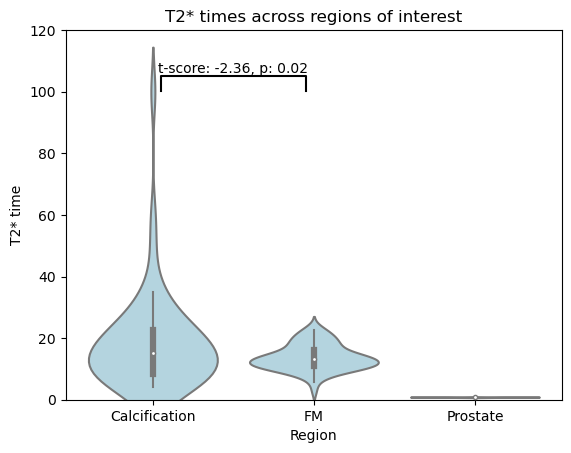

In [40]:
sns.violinplot(combined_df, x='Type', y='mean', fliersize=0, color='lightblue', scale='width')
x1, x2 = 0.05, 0.95
y, h, col = combined_df['mean'].max() + 0.15, 0.03, 'k'  # y is the height of the bracket, h is the length of the bracket ends, col is the color
h = y * 0.05
#y, h, col = 0.25, .025, 'k'

plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)  # Draw the bracket
plt.text((x1+x2)*.5, y+h+0.03, f"t-score: {np.round(t_stat, 2)}, p: {np.round(p_value, 2)}", ha='center', va='bottom', color=col)  # Put the statistics
#plt.ylim(-1.1, +0.4)
plt.title("T2* times across regions of interest")
plt.ylim(0, 120)
plt.ylabel("T2* time")
plt.xlabel("Region")
plt.savefig("t2s_values.png", dpi=400)

12


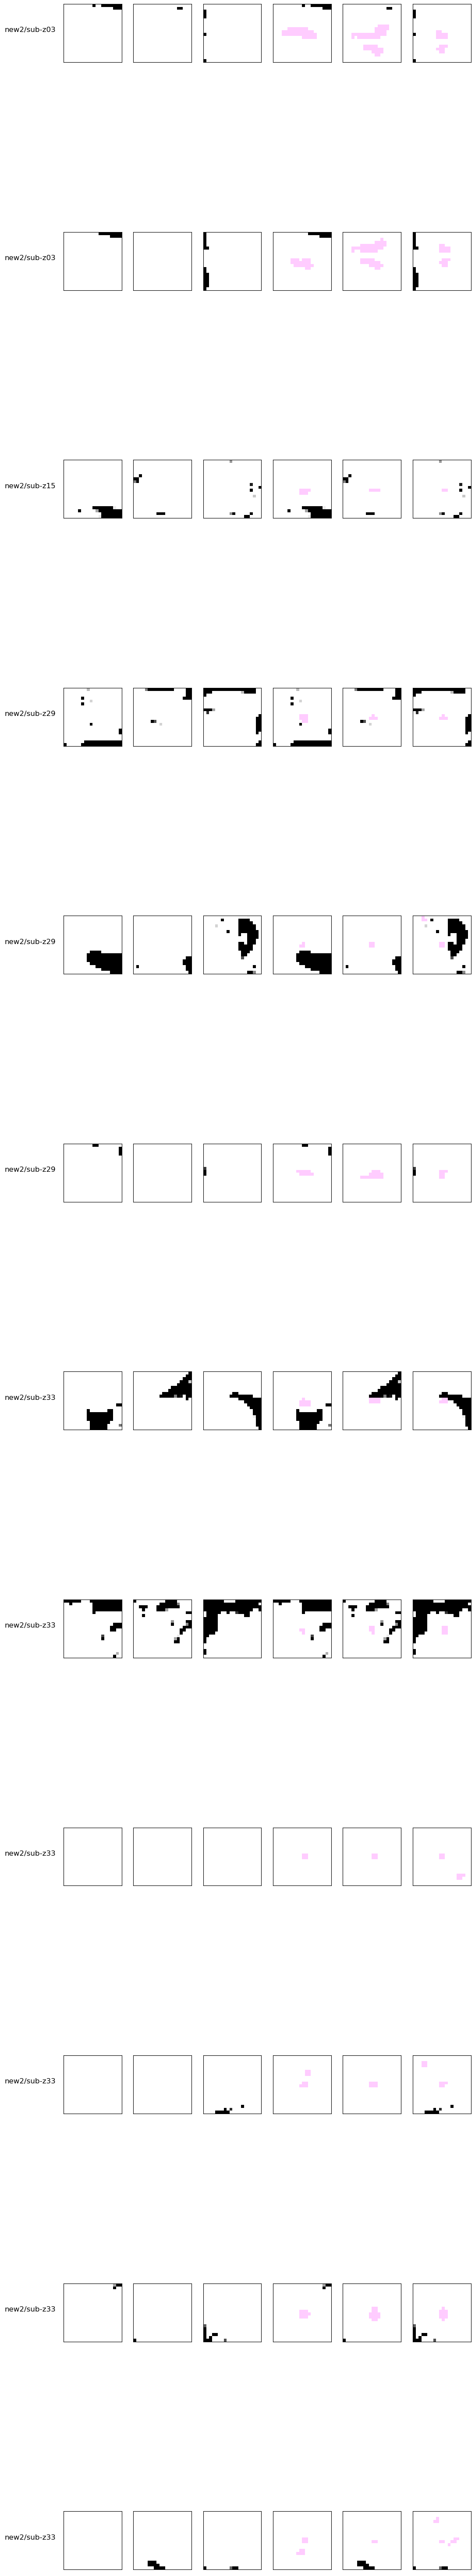

In [28]:
fig, axes = plt.subplots(ncols=6, nrows=len(regions_vals), figsize=(12, 80))

for ax in axes.flat:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

print(len(regions_vals))
for i in range(len(regions_vals)):
    axes[i,0].imshow(regions_vals[i][regions_vals[i].shape[0]//2,:,:], cmap='gray', vmin=-1, vmax=+1)
    axes[i,1].imshow(regions_vals[i][:,regions_vals[i].shape[1]//2,:], cmap='gray', vmin=-1, vmax=+1)
    axes[i,2].imshow(regions_vals[i][:,:,regions_vals[i].shape[2]//2], cmap='gray', vmin=-1, vmax=+1)

    axes[i,3].imshow(regions_vals[i][regions_vals[i].shape[0]//2,:,:], cmap='gray', vmin=-1, vmax=+1)
    axes[i,4].imshow(regions_vals[i][:,regions_vals[i].shape[1]//2,:], cmap='gray', vmin=-1, vmax=+1)
    axes[i,5].imshow(regions_vals[i][:,:,regions_vals[i].shape[2]//2], cmap='gray', vmin=-1, vmax=+1)

    axes[i,3].imshow(regions_masks[i][regions_vals[i].shape[0]//2,:,:], cmap='cool', alpha=np.array(regions_masks[i][regions_vals[i].shape[0]//2,:,:] * 0.2, dtype=float), vmin=0, vmax=1)
    axes[i,4].imshow(regions_masks[i][:,regions_vals[i].shape[1]//2,:], cmap='cool', alpha=np.array(regions_masks[i][:,regions_vals[i].shape[1]//2,:] * 0.2, dtype=float), vmin=0, vmax=1)
    axes[i,5].imshow(regions_masks[i][:,:,regions_vals[i].shape[2]//2], cmap='cool', alpha=np.array(regions_masks[i][:,:,regions_vals[i].shape[2]//2] * 0.2, dtype=float), vmin=0, vmax=1)

    axes[i,0].set_ylabel(regions_segmentations[i][5:17], rotation=0, fontsize=12, labelpad=55)

plt.savefig("seeds.png", bbox_inches='tight')
plt.show()
plt.close()